<a href="https://colab.research.google.com/github/opherdonchin/Regression-by-group/blob/main/Regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I built this using the outline in this page: [Bayesian Linear Regression Using PyMC3](https://ostwalprasad.github.io/machine-learning/Bayesian-Linear-Regression-using-PyMC3.html)

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install pymc3
    !pip install seaborn
    !pip install arviz

In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
import pickle
import theano.tensor as tt


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# url_impl_trials = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/dataExplicit.csv'
# url_expl_trials = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/dataExplicit.csv'
# url_impl = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/implAndAfter_NoLandmarks.csv'
# url_expl = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/implAndAfter_NoLandmarks.csv'
url_landmarks = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/data/dataLandmarks.csv'
url_no_landmarks = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/data/dataNoLandmarks.csv'


landmark_data = pd.read_csv(url_landmarks, sep=",", on_bad_lines='skip')
no_landmark_data = pd.read_csv(url_no_landmarks, sep=",", on_bad_lines='skip')

In [4]:
landmark_data.head()

,eyeHandDiff,eyes,afterEffect,subjectN,groups
0,10.082297,-31.546520,-8.875644,1,1
1,-10.012122,-27.271097,-3.625990,1,1
2,-33.441301,14.607681,-15.002860,1,1
3,-95.241374,57.084439,-11.144006,1,1
4,-121.630474,99.886312,-17.726672,1,1


In [5]:
print('Running on the PyMC3 v{}'.format(pm.__version__))


Running on the PyMC3 v3.11.4


In [6]:
def homogeneuos_model(y,x,s):
  s_idx, s_vals = pd.factorize(s, sort=True)
  coords = {"subject": s_vals}
  with pm.Model(coords=coords) as model:
    #Priors
    beta = pm.Normal('beta', mu=0, sd=10, testval=0.0)
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(5.0), compute_corr=True)
    # Deterministics
    xs = pm.Normal('xs', mu=0, sd=30, testval=0.0, dims="subject")
    mu = beta*xs
    ys = pm.Normal('ys', mu=mu, sd=30, testval=0.0, dims="subject")
    mu_o = tt.stack([xs,ys]).T
    # Likelihood 
    obs = pm.MvNormal('obs', mu=mu_o[s_idx,:], chol=chol, observed=np.array([o for o in zip(x,y)]))
    
  return model



In [7]:
this_data = no_landmark_data.loc[no_landmark_data["groups"]==1,:]
x = this_data["eyeHandDiff"]
y = this_data["afterEffect"]
s = this_data["subjectN"]

m = homogeneuos_model(y,x,s)

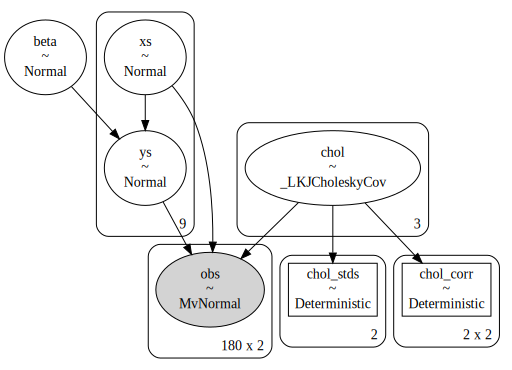

In [9]:
pm.model_to_graphviz(m)

In [10]:
with m:
    trace = pm.sample(draws=10000, tune=1000, cores=4)
az_trace = az.from_pymc3(trace=trace,model=m)

C:\Users\Opher local\AppData\Local\Temp\ipykernel_3020\3883679503.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=10000, tune=1000, cores=4)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ys, xs, chol, beta]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 169 seconds.


c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: invalid value encountered in true_divid

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'xs'}>,
        <AxesSubplot:title={'center':'xs'}>],
       [<AxesSubplot:title={'center':'ys'}>,
        <AxesSubplot:title={'center':'ys'}>],
       [<AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'chol'}>],
       [<AxesSubplot:title={'center':'chol_stds'}>,
        <AxesSubplot:title={'center':'chol_stds'}>],
       [<AxesSubplot:title={'center':'chol_corr'}>,
        <AxesSubplot:title={'center':'chol_corr'}>]], dtype=object)

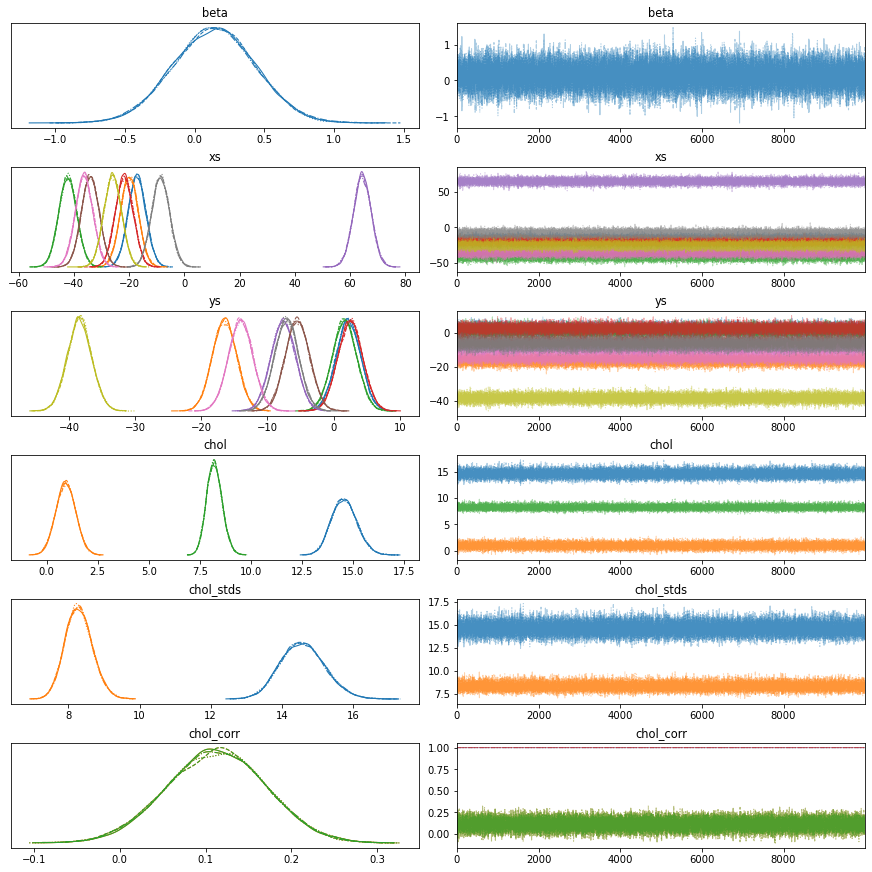

In [11]:
az.plot_trace(az_trace)

In [12]:
pm.summary(az_trace).round(2)

c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.14,0.29,-0.41,0.69,0.00,0.00,66979.0,31517.0,1.0
xs[0],-17.16,3.21,-23.02,-10.88,0.01,0.01,65816.0,31424.0,1.0
xs[1],-19.93,3.24,-26.11,-13.94,0.01,0.01,65409.0,30786.0,1.0
xs[2],-42.23,3.24,-48.40,-36.22,0.01,0.01,69103.0,29741.0,1.0
xs[3],-21.75,3.23,-27.84,-15.74,0.01,0.01,68017.0,30774.0,1.0
xs[4],64.44,3.22,58.48,70.57,0.01,0.01,67459.0,30322.0,1.0
xs[5],-34.07,3.22,-40.16,-28.02,0.01,0.01,73167.0,31655.0,1.0
xs[6],-36.29,3.22,-42.40,-30.27,0.01,0.01,67493.0,30649.0,1.0
xs[7],-8.63,3.24,-14.78,-2.59,0.01,0.01,65945.0,29700.0,1.0
xs[8],-25.95,3.20,-31.87,-19.87,0.01,0.01,67511.0,31069.0,1.0


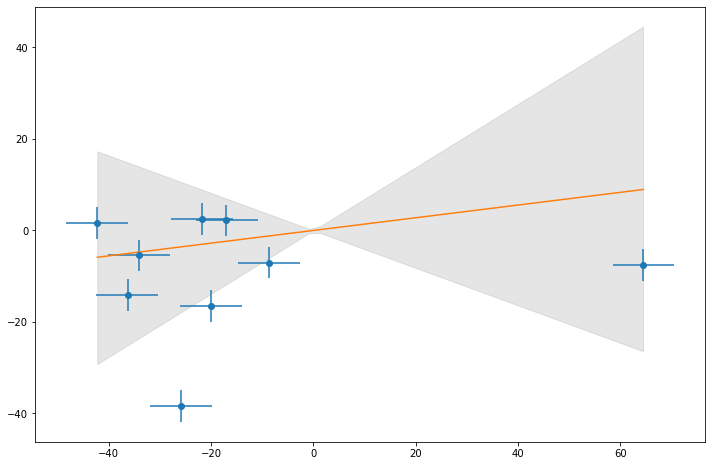

In [15]:
post = az_trace.posterior
post_mean = post[["xs","ys"]].mean(dim=['chain', 'draw'])
post_hdi = az.hdi(post[["xs","ys"]])

x_mean = post_mean["xs"]
y_mean = post_mean["ys"]
x_upper = post_hdi["xs"].sel({"hdi":"higher"}) - x_mean
x_lower = x_mean - post_hdi["xs"].sel({"hdi":"lower"})
y_upper = post_hdi["ys"].sel({"hdi":"higher"}) - y_mean
y_lower = y_mean - post_hdi["ys"].sel({"hdi":"lower"})
    
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(x_mean, y_mean, xerr=[x_lower, x_upper], yerr=[y_lower, y_upper], fmt='o')

x_hat = np.linspace(np.min(x_mean), np.max(x_mean), 50)
beta = post["beta"].mean().to_numpy()
y_hat = x_hat*beta

ax.plot(x_hat, y_hat)

beta_trace = post["beta"]
y_lower = list()
y_higher = list()
for x_mod in x_hat:
    y_mod_trace = beta_trace*x_mod
    y_mod_hdi = az.hdi(y_mod_trace).to_array().to_numpy()
    y_lower.append(y_mod_hdi[0][0])
    y_higher.append(y_mod_hdi[0][1])
ax.fill_between(x_hat, y_lower, y_higher, color='grey', alpha=0.2)

